In [20]:
import pandas as pd
import numpy as np
import pysindy as ps
import math
from numpy import diff

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso

### Case 1: Single column with 200 trials

In [21]:
# t = pd.read_csv (r'C:\Users\l2016\GitHub\nonlinear-brain-mass-model\data-fit\data-62-t.csv')
# x = pd.read_csv (r'C:\Users\l2016\GitHub\nonlinear-brain-mass-model\data-fit\data-62-x.csv')
# xdot = pd.read_csv (r'C:\Users\l2016\GitHub\nonlinear-brain-mass-model\data-fit\data-62-xdot.csv')
# t = pd.read_csv (r'C:\Users\l2016\GitHub\nonlinear-brain-mass-model\data-fit\data-63-t.csv')
# x = pd.read_csv (r'C:\Users\l2016\GitHub\nonlinear-brain-mass-model\data-fit\data-63-x.csv')
# xdot = pd.read_csv (r'C:\Users\l2016\GitHub\nonlinear-brain-mass-model\data-fit\data-63-xdot.csv')
iteration = 200
t = []
x = []
xdot = []

for i in range (1,iteration+1):
    curT = pd.read_csv (r'C:\Users\l2016\GitHub\nonlinear-brain-mass-model\data-gen\single-column-data\No.'+str(i)+' data-t.csv')
    curX = pd.read_csv (r'C:\Users\l2016\GitHub\nonlinear-brain-mass-model\data-gen\single-column-data\No.'+str(i)+' data-x.csv')
    curXdot = pd.read_csv (r'C:\Users\l2016\GitHub\nonlinear-brain-mass-model\data-gen\single-column-data\No.'+str(i)+' data-xdot.csv')

    t.append(curT.to_numpy()) 
    x.append(curX.to_numpy()) 
    xdot.append(curXdot.to_numpy())

print(x[0].shape)
# print(type(x))
print(len(t))
print(t[1].shape)

(15501, 8)
200
(15501, 1)


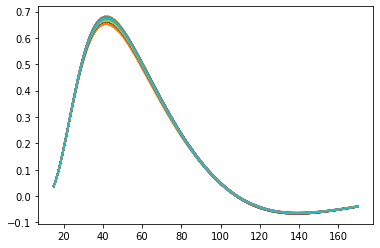

In [22]:
i = 0
for trl in x:
    cl1 = trl[:,1] - trl[:,2]
    plt.plot(t[i], cl1)
    i += 1

###  Create the training dataset

In [23]:
#split the data in half 
#calculate the indexes for each set
trainEd = math.floor(x[0].shape[0]/2)
print('end training index',trainEd)
testStr = trainEd+1
testEd = x[0].shape[0]
print('end testing index', testEd)

end training index 7750
end testing index 15501


In [31]:
#training data
t_train = []
x_train = []
xdot_train = []

for i in range (iteration):
    #append the training values of t 
    t_train.append(t[i][0:trainEd,0])
      
    #######Option 1 include y
#     #compute the y term by 2nd column X - 3rd column X
#     y = np.array([x[i][0:trainEd,1] - x[i][0:trainEd,2]]) 
#     #concatenate the y term to a tempX
#     tempX = np.concatenate((x[i][0:trainEd], y.T), axis=1)    
#     #append the concatenation result to x_train
#     x_train.append(tempX)
#     #compute the y_dot term by 2nd column Xdot - 3rd column Xdot
#     yDot = np.array([xdot[i][0:trainEd,1] - xdot[i][0:trainEd,2]])
#     #concatenate the y_dot term to a temp
#     tempYdot = np.concatenate((xdot[i][0:trainEd], yDot.T), axis=1)
#     #append the concatenation result to x_dot_train
#     xdot_train.append(tempYdot)
    
    #######Option 2 not include y
    x_train.append(x[i][0:trainEd,:])
    xdot_train.append(xdot[i][0:trainEd,:])
    
    

    
#print check the shape
####Option 1
# print(y.shape)
# print(tempX.shape)
# print(yDot.shape)
# print(tempYdot.shape)
# print(len(xdot_train))
####Option 2
print(len(t_train))
print(len(x_train))
print(len(xdot_train))
print(t_train[0].shape)
print(x_train[0].shape)
print(xdot_train[0].shape)

# test 2
#I will try to include u as one of the training input as well
#can I fit u to a single hill wave function with reasonable width
#and then pass it to the model as a input

200
200
200
(7750,)
(7750, 8)
(7750, 8)


### Fit the Sindy with the training dataset

In [39]:
#I will initial with only 2 functions: one is x 
# the other is the sigmoid-liked function
library_functions = [
    lambda x : x,
    lambda x : -2.5+5/(1+np.exp(-0.56*x)) #-e0+2*e0/(1+exp(-r*x))
]
library_function_names = [
    lambda x : x,
    lambda x : 'S(' + x + ')'
]

custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

In [42]:
#pass the x and its derivative
#Threshold:
#minimum coefficient 0.0026 hi*gamma4/ti
optimizer = ps.STLSQ(threshold=0.001)
feature_library=custom_library
dt = 0.01
model = ps.SINDy(
    feature_library=feature_library,
    optimizer = optimizer
)
model.fit(x_train, t=t_train, x_dot=xdot_train,multiple_trajectories=True)
model.print()

(x0)' = 1.000 x3
(x1)' = 1.000 x4
(x2)' = 1.000 x5
(x3)' = 0.001 x0 + 0.009 x1 + 0.005 x2 + -4.953 x3 + -18.778 x4 + 0.013 x6 + 7981.583 x7 + -0.018 S(x0) + -0.016 S(x2) + 6.799 S(x3) + 26.898 S(x4) + -11401.878 S(x7)
(x4)' = -0.005 x0 + 0.009 x1 + 0.018 x2 + -10.030 x3 + 49.116 x4 + 2956.967 x5 + -3.622 x6 + 11709.600 x7 + 0.017 S(x0) + -0.033 S(x1) + -0.017 S(x2) + 14.339 S(x3) + -70.361 S(x4) + -4224.243 S(x5) + 5.200 S(x6) + -16727.537 S(x7)
(x5)' = 0.001 x0 + -0.005 x1 + 0.024 x2 + 17.778 x4 + 782.881 x5 + -0.036 x6 + 352.759 x7 + -0.002 S(x0) + 0.007 S(x1) + -0.040 S(x2) + -25.404 S(x4) + -1118.555 S(x5) + 0.070 S(x6) + -503.920 S(x7)
(x6)' = 1.000 x7
(x7)' = -0.004 x0 + 0.442 x4 + -217.908 x5 + 0.841 x6 + -735.002 x7 + 0.006 S(x0) + 0.003 S(x2) + -0.607 S(x4) + 311.337 S(x5) + -1.210 S(x6) + 1050.065 S(x7)


### Score for the time derivative prediction produced by the model

In [44]:
#multiple trajctories for this
#training data
t_test = []
x_test = []
xdot_test = []
for i in range (iteration):
    t_test.append(t[i][testStr:testEd,0])
    x_test.append(x[i][testStr:testEd,:])
    xdot_test.append(xdot[i][testStr:testEd,:])
    
#x_test can have 200 trails
print('Model score: %f' % model.score(x_test, t = t_test, x_dot = xdot_test, multiple_trajectories=True))

Model score: 0.694339


### Plots for test data time derivative  comperation

[ 3.63736304e-01  5.22289018e-01  4.17527921e-01 -1.27257062e-02
 -9.07639686e-03 -3.08805495e-04  8.57076779e-02 -2.90868076e-03]


C:\Users\l2016\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


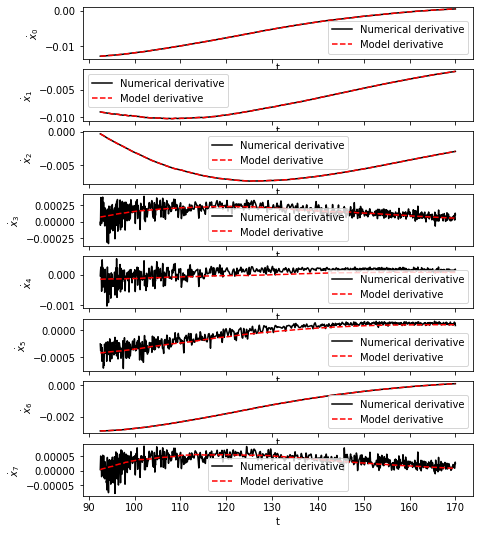

In [51]:
print(x_test[0][0,:])
#x test doing split
xdot_predicted = model.predict(x_test, multiple_trajectories=True)

fig, axs = plt.subplots(x_test[0].shape[1], 1, sharex=True, figsize=(7, 9))

for i in range(x_test[0].shape[1]):
    for j in range(1):
        axs[i].plot(t_test[j], xdot_test[j][:, i],'k')
        axs[i].plot(t_test[j], xdot_predicted[j][:, i],'r--')
        
    axs[i].legend(['Numerical derivative', 'Model derivative'])
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
fig.show()

### Generate model prediction X

In [52]:
# time interval of the simulation
dt = 0.1
t_sim = np.arange(15, 250, dt)

# use the x_train at 15 ms value as initial condition
    #the 2nd index is 15s
x0_sim = x_train[0][1,:]
#print(x0_test)

x_test_sim = model.simulate(x0_sim, t_sim)
print('dimension of the x_test_simulation:', x_test_sim.shape)

dimension of the x_test_simulation: (2350, 8)


### Plots for model prediction performance

In [53]:
#simulation result
cl1_sim = x_test_sim[:,1] - x_test_sim[:,2]

#real value
cl1 = x[0][:,1] - x[0][:,2]

(-1, 1)

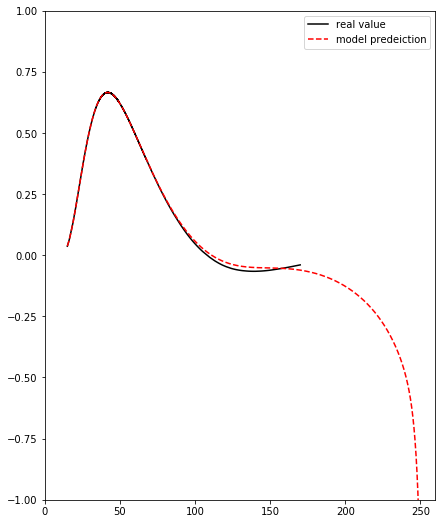

In [59]:
fig, ax = plt.subplots(figsize=(7, 9))
ax.plot(t[0], cl1,'k')
ax.plot( t_sim, cl1_sim, 'r--')
ax.legend(['real value','model predeiction'])
ax.set_xlim([0, 260])
ax.set_ylim([-1, 1])

### Numerical performance of the model on the test data

In [ ]:
#calculate the performance by 1 - the SE/sum of all data points 